# Sieć służąca do klasyfikacji pastylek leków - trening
Wykonał Bartłomiej Tarcholik

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import keras
import os
from keras import layers
from keras import models
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import cv2
import json
import random
import math
import copy

Poprzez zastosowanie datagenu do tworzenia datasetu zdecydowałem się na praktycznie zerowe ingerencje w obrazy w trakcie treningu.

In [10]:
img_rows = 64
img_cols = 64
shape_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30)

shape_test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'C:/ml/data/pills/deploy/train'
val_dir = 'C:/ml/data/pills/deploy/val'

shape_train_generator = shape_train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_rows, img_cols),
        batch_size=20,
        class_mode='categorical')

shape_validation_generator = shape_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_rows, img_cols),
        batch_size=20,
        class_mode='categorical')

Found 6174 images belonging to 6 classes.
Found 6080 images belonging to 6 classes.


## Algorytm ewolucyjny
Napisałem algorytm ewolucyjny, który przyjmuje do siebie listę danych i na jej podstawie buduje wiele modeli, które następnie szkoli i tworzy ranking. Najlepsze modele są wybierane jako "dawcy" cech do nowego zestawu danych, który następnie jest podawany do funkcji. Kiedy nie będzie już prawie żadnej poprawy nad istniejącymi modelami, algorytm kończy działanie i zwraca pełną listę danych o modelach oraz ich sprawności.

In [3]:
def ListEqual(a, b):
    if len(a) != len(b):
        return False
    else:
        for i in range(len(a)):
            if isinstance(a[i], list) and isinstance(b[i], list):
                if not ListEqual(a[i], b[i]):
                    return False
            else:
                if isinstance(a[i], list) or isinstance(b[i], list):
                    return False
                else:
                    if a[i] != b[i]:
                        return False
    return True

def IsModelUnique(m_list, n_list, m_data):
    for m in m_list:
        data = m[5]
        if ListEqual(data, m_data):
            return False
    for n in n_list:
        if ListEqual(n, m_data):
            return False
    return True
    
def GetCombo(a, b, m_l, n_l):
    resultData = []
    for i in range(0, len(a)):
        if a[i] != b[i]:
            if isinstance(a[i], int):
                avg = int(round((a[i] + b[i]) / 2))
                m = a.copy()
                m[i] = avg
                if IsModelUnique(m_l, n_l, m):
                    resultData.append(m)
            else:
                m = a.copy()
                m[i] = b[i]
                if IsModelUnique(m_l, n_l, m):
                    resultData.append(m)
    return resultData

def EvolveBest(inputShape, dataList, modelMakingFunction, nC, percentage, trainData, valData, ep, epochSteps, model_list, currentBest, no_classes):
    # inputShape jest zawsze stałe, więc będzie osobne od listy
    newModelList = []
    for x in range(0, len(dataList)):
        model, name = modelMakingFunction(inputShape, dataList[x], nC, no_classes)
        color = RandomColor()
        history = model.fit(
            trainData,
            steps_per_epoch=epochSteps,
            epochs=ep,
            validation_data=valData,
            validation_steps=math.ceil(epochSteps / 2),
            verbose=0)
        model_list.append([model, name, history.history, max(history.history['val_acc']), history.history['acc'][-1], dataList[x], color])
        newModelList.append([model, name, history.history, max(history.history['val_acc']), history.history['acc'][-1], dataList[x], color])
        print("Model", name, "trained")
    
    # Sortujemy listę modeli po wyniku walidacji
    model_list.sort(key=lambda x: x[3], reverse=True)
    newModelList.sort(key=lambda x: x[3], reverse=True)
    # Jeśli najnowszy najlepszy model nie jest lepszy od dotychczasowego o przynajmniej 1%, kończymy zabawę
    if newModelList[0][3] < currentBest * 1.01 or len(newModelList) < 2:
        return model_list
    else:
        goodData = []
        for entry in model_list:
            if entry[3] > percentage * currentBest and len(goodData) < 3:
                    goodData.append(entry[5])

        newData = []
        if len(goodData) > 1:
            for i in range(0, len(goodData)):
                for j in range(0, len(goodData)):
                    if i != j:
                        newData += GetCombo(goodData[i], goodData[j], model_list, newData)
        # Mamy dane które potrzebujemy, teraz należy przesłać do funkcji rekurencyjnie
        return EvolveBest(
            inputShape,
            newData, # dane z których mają być tworzone modele
            modelMakingFunction, # tutaj SimpleMaker
            nC,
            percentage,
            trainData,
            valData,
            ep,
            epochSteps,
            model_list,
            model_list[0][3],
            no_classes)

def SimpleMaker(i_sh, data, neuronIncreaseCutoff, no_cla):
    layerCount = data[0]
    baseNeuronCount = 2 ** data[1]
    denseNeurons = 2 ** data[2]
    activationF = data[3]
    if activationF == 'leaky_relu':
        aF = tf.keras.layers.LeakyReLU(alpha=0.3)
    else:
        aF = activationF
    opt = data[4]

    model = models.Sequential()
    layerInfo = ""
    for i in range(0, layerCount):
        neur = 0
        if i < neuronIncreaseCutoff:
            neur = baseNeuronCount * (2 ** i)
        else:
            neur = baseNeuronCount * (2 ** neuronIncreaseCutoff)
        layerInfo += str(neur) + "-"
        if i == 0:
            model.add(layers.Conv2D(neur, (3, 3), activation=aF, input_shape=i_sh, padding='same'))
            model.add(layers.MaxPooling2D((2,2)))
        else:
            model.add(layers.Conv2D(neur, (3, 3), activation=aF, padding='same'))
            model.add(layers.MaxPooling2D((2,2)))
            
    model.add(layers.Flatten())
    model.add(layers.Dense(denseNeurons, activation=aF))
    model.add(layers.Dense(no_cla, activation='softmax'))
    name = "L:" + layerInfo + " dns:" + str(denseNeurons) + " " + activationF + " " + opt
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])
    return model, name

def RandomColor():
    random_number = random.randint(0, 16777215)
    hex_number = str(hex(random_number))
    return '#' + f'{"%06x" % random.randint(0, 0xFFFFFF)}'


def PlotAccuracyComparison(m_list):
    plt.clf()
    plt.figure(figsize=(25, 15))
    for m in m_list:
        r_color = m[6]
        name = m[1]
        history = m[2]
        accuracy = history['acc']
        validation_accuracy = history['val_acc']
        epochs = range(len(accuracy))
        plt.plot(epochs, validation_accuracy, label ='Validation accuracy: ' + str(round(m[3] * 100, 2)) +' for ' + name, color=r_color)
        plt.plot(epochs, accuracy, 'o', label ='Training accuracy: ' + str(round(m[4] * 100, 2)) +' for ' + name, color=r_color)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()


def PlotLossComparison(m_list):
    plt.clf()
    plt.figure(figsize=(25, 15))
    for m in m_list:
        r_color = m[6]
        name = m[1]
        history = m[2]
        loss = history['loss']
        validation_loss = history['val_loss']
        epochs = range(len(loss))
        plt.plot(epochs, loss, 'o', label='Training loss for ' + name, color=r_color)
        plt.plot(epochs, validation_loss, label='Validation loss for ' + name, color=r_color)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

Dane startowe modeli wychodzą wszystkie z jednego modelu z następującymi parametrami zmiennymi:
- 5 warstw konwolucyjnych
- 32 neurony startowe
- 256 neuronów w warstwie gęstej przed warstwą wyjściową
- funkcja aktywacji ReLU
- optymalizator RMSProp
oraz stałą funkcją wyjściową Softmax z 6 neuronami w warstwie końcowej (tyle jest klas)

In [12]:
modelData = [
    [
        5, 5, 8, 'leaky_relu',"rmsprop"
    ],
    [
        5, 5, 8, 'relu',"rmsprop"
    ],
    [
        3, 4, 6, 'relu',"rmsprop"
    ],
    [
        3, 5, 8, 'relu', "rmsprop"
    ],
    [
        6, 5, 8, 'relu', "rmsprop"
    ],
    [
        5, 3, 8, 'relu', "rmsprop"
    ],
    [
        5, 7, 8, 'relu', "rmsprop"
    ],
    [
        5, 5, 6, 'relu',"rmsprop"
    ],
    [
        5, 5, 10, 'relu',"rmsprop"
    ],
    [
        5, 5, 8, 'relu',"adam"
    ],
    [
        5, 5, 8, 'relu',"sgd"
    ]
]

training_shape =(64,64,3)

### Neuron Cut-off, czyli mój sposób na automatyzację różnych sposobów tworzenia warstw konwolucyjnych
Jednym ze wprowadzonych przeze mnie parametrów jest Neuron Increase Cut-off, czyli od po ilu warstwach ilość neuronów na warstwę przestaje rosnąć. Wykonałem 3 szkolenia, dla wartości NIC 1, 2 oraz 3.

In [25]:
import json
modelList = []
nc1 = EvolveBest(
    training_shape,
    modelData,
    SimpleMaker,
    1, # Neuron Increase Cutoff
    0.9, # Percentage of required best
    shape_train_generator,
    shape_validation_generator,
    100,
    100,
    modelList,
    0,
    6)

for i in range(len(nc1)):
  el = nc1[i]
  model = el[0]
  name = el[1]
  his = el[2]
  max_val = el[3]
  last_acc = el[4]
  data = el[5]
  color = el[6]
  model.save('C:/ml/models/pillsNC1/' + str(i + 1) + '.h5')
  toSave = [
    name,
    his,
    max_val,
    last_acc,
    data,
    color,
  ]
  json.dump(toSave, open('C:/ml/models/pillsNC1/' + str(i + 1) + '.json', 'w'))

Model L:32-64-64-64-64- dns:256 leaky_relu rmsprop trained
Model L:32-64-64-64-64- dns:256 relu rmsprop trained
Model L:16-32-32- dns:64 relu rmsprop trained
Model L:32-64-64- dns:256 relu rmsprop trained
Model L:32-64-64-64-64-64- dns:256 relu rmsprop trained
Model L:8-16-16-16-16- dns:256 relu rmsprop trained
Model L:128-256-256-256-256- dns:256 relu rmsprop trained
Model L:32-64-64-64-64- dns:64 relu rmsprop trained
Model L:32-64-64-64-64- dns:1024 relu rmsprop trained
Model L:32-64-64-64-64- dns:256 relu adam trained
Model L:32-64-64-64-64- dns:256 relu sgd trained
Model L:32-64-64-64-64-64- dns:256 relu adam trained


In [26]:
modelList = []
nc2 = EvolveBest(
    training_shape,
    modelData,
    SimpleMaker,
    2, # Neuron Increase Cutoff
    0.9, # Percentage of required best
    shape_train_generator,
    shape_validation_generator,
    100,
    100,
    modelList,
    0,
    6)

for i in range(len(nc2)):
  el = nc2[i]
  model = el[0]
  name = el[1]
  his = el[2]
  max_val = el[3]
  last_acc = el[4]
  data = el[5]
  color = el[6]
  model.save('C:/ml/models/pillsNC2/' + str(i + 1) + '.h5')
  toSave = [
    name,
    his,
    max_val,
    last_acc,
    data,
    color,
  ]
  json.dump(toSave, open('C:/ml/models/pillsNC2/' + str(i + 1) + '.json', 'w'))

Model L:32-64-128-128-128- dns:256 leaky_relu rmsprop trained
Model L:32-64-128-128-128- dns:256 relu rmsprop trained
Model L:16-32-64- dns:64 relu rmsprop trained
Model L:32-64-128- dns:256 relu rmsprop trained
Model L:32-64-128-128-128-128- dns:256 relu rmsprop trained
Model L:8-16-32-32-32- dns:256 relu rmsprop trained
Model L:128-256-512-512-512- dns:256 relu rmsprop trained
Model L:32-64-128-128-128- dns:64 relu rmsprop trained
Model L:32-64-128-128-128- dns:1024 relu rmsprop trained
Model L:32-64-128-128-128- dns:256 relu adam trained
Model L:32-64-128-128-128- dns:256 relu sgd trained
Model L:32-64-128-128-128- dns:128 relu adam trained
Model L:32-64-128-128-128- dns:256 leaky_relu adam trained
Model L:32-64-128-128-128- dns:128 relu rmsprop trained
Model L:32-64-128-128-128- dns:64 relu adam trained
Model L:32-64-128-128-128- dns:64 leaky_relu rmsprop trained
Model L:32-64-128-128-128- dns:128 leaky_relu rmsprop trained


In [27]:
modelList = []
nc3 = EvolveBest(
    training_shape,
    modelData,
    SimpleMaker,
    3, # Neuron Increase Cutoff
    0.9, # Percentage of required best
    shape_train_generator,
    shape_validation_generator,
    100,
    100,
    modelList,
    0,
    6)

for i in range(len(nc3)):
  el = nc3[i]
  model = el[0]
  name = el[1]
  his = el[2]
  max_val = el[3]
  last_acc = el[4]
  data = el[5]
  color = el[6]
  model.save('C:/ml/models/pillsNC3/' + str(i + 1) + '.h5')
  toSave = [
    name,
    his,
    max_val,
    last_acc,
    data,
    color,
  ]
  json.dump(toSave, open('C:/ml/models/pillsNC3/' + str(i + 1) + '.json', 'w'))

Model L:32-64-128-256-256- dns:256 leaky_relu rmsprop trained
Model L:32-64-128-256-256- dns:256 relu rmsprop trained
Model L:16-32-64- dns:64 relu rmsprop trained
Model L:32-64-128- dns:256 relu rmsprop trained
Model L:32-64-128-256-256-256- dns:256 relu rmsprop trained
Model L:8-16-32-64-64- dns:256 relu rmsprop trained
Model L:128-256-512-1024-1024- dns:256 relu rmsprop trained
Model L:32-64-128-256-256- dns:64 relu rmsprop trained
Model L:32-64-128-256-256- dns:1024 relu rmsprop trained
Model L:32-64-128-256-256- dns:256 relu adam trained
Model L:32-64-128-256-256- dns:256 relu sgd trained
Model L:32-64-128-256-256- dns:256 leaky_relu adam trained
Model L:32-64-128-256-256- dns:128 leaky_relu rmsprop trained
Model L:32-64-128-256-256- dns:128 relu adam trained
Model L:32-64-128-256-256- dns:128 relu rmsprop trained
Model L:32-64-128-256-256- dns:64 leaky_relu rmsprop trained
Model L:32-64-128-256-256- dns:64 relu adam trained


Po wyszkoleniu zapisałem najlepsze 3 modele z każdej opcji NIC, a następnie stworzyłem nowe modele z ich danych i wytrenowałem je do ilości epok, która była optymalna.

In [15]:
bestNC1 = []
for b in nc1[0:3]:
  newModel, name = SimpleMaker(training_shape, b[5], 1, 6)
  color = RandomColor()
  history = newModel.fit(
      shape_train_generator,
      steps_per_epoch=100,
      epochs=np.argmax(b[2]['val_acc']),
      validation_data=shape_validation_generator,
      validation_steps=50,
      verbose=0)
  bestNC1.append([newModel, name, history.history, max(history.history['val_acc']), history.history['acc'][-1], b[5], color])
  print("Model", name, "trained")

Model L:32-64-64-64-64- dns:256 relu adam trained
Model L:32-64-64-64-64- dns:256 relu rmsprop trained
Model L:32-64-64-64-64-64- dns:256 relu adam trained


In [13]:
bestNC2 = []
for b in nc2[0:3]:
  newModel, name = SimpleMaker(training_shape, b[5], 2, 6)
  color = RandomColor()
  history = newModel.fit(
      shape_train_generator,
      steps_per_epoch=100,
      epochs=np.argmax(b[2]['val_acc']),
      validation_data=shape_validation_generator,
      validation_steps=50,
      verbose=0)
  bestNC2.append([newModel, name, history.history, max(history.history['val_acc']), history.history['acc'][-1], b[5], color])
  print("Model", name, "trained")

Model L:32-64-128-128-128- dns:128 relu adam trained
Model L:32-64-128-128-128- dns:256 relu adam trained
Model L:32-64-128-128-128- dns:64 relu adam trained


In [14]:
bestNC3 = []
for b in nc3[0:3]:
  newModel, name = SimpleMaker(training_shape, b[5], 3, 6)
  color = RandomColor()
  history = newModel.fit(
      shape_train_generator,
      steps_per_epoch=100,
      epochs=np.argmax(b[2]['val_acc']),
      validation_data=shape_validation_generator,
      validation_steps=50,
      verbose=0)
  bestNC3.append([newModel, name, history.history, max(history.history['val_acc']), history.history['acc'][-1], b[5], color])
  print("Model", name, "trained")

Model L:32-64-128-256-256- dns:64 relu adam trained
Model L:32-64-128-256-256- dns:256 leaky_relu rmsprop trained
Model L:32-64-128-256-256- dns:128 relu adam trained


In [20]:
for m1, m2, m3 in zip(bestNC1, bestNC2, bestNC3):
  m1[1] += " trained for " + str(len(m1[2]['val_acc'])) + " epochs"
  m2[1] += " trained for " + str(len(m2[2]['val_acc'])) + " epochs"
  m3[1] += " trained for " + str(len(m3[2]['val_acc'])) + " epochs"

for b in bestNC1:
  print(b[1])


for b in bestNC2:
  print(b[1])


for b in bestNC3:
  print(b[1])

L:32-64-64-64-64- dns:256 relu adam trained for 77 epochs
L:32-64-64-64-64- dns:256 relu rmsprop trained for 73 epochs
L:32-64-64-64-64-64- dns:256 relu adam trained for 93 epochs
L:32-64-128-128-128- dns:128 relu adam trained for 70 epochs
L:32-64-128-128-128- dns:256 relu adam trained for 50 epochs
L:32-64-128-128-128- dns:64 relu adam trained for 85 epochs
L:32-64-128-256-256- dns:64 relu adam trained for 85 epochs
L:32-64-128-256-256- dns:256 leaky_relu rmsprop trained for 96 epochs
L:32-64-128-256-256- dns:128 relu adam trained for 90 epochs


In [21]:
for i in range(3):
  bestNC1[i][0].save('C:/ml/models/pills_best3_retrained_NC1/' + str(i + 1) + '.h5')
  toSave1 = [
    bestNC1[i][1],
    bestNC1[i][2],
    bestNC1[i][3],
    bestNC1[i][4],
    bestNC1[i][5],
    bestNC1[i][6],
  ]
  json.dump(toSave1, open('C:/ml/models/pills_best3_retrained_NC1/' + str(i + 1) + '.json', 'w'))
  bestNC2[i][0].save('C:/ml/models/pills_best3_retrained_NC2/' + str(i + 1) + '.h5')
  toSave2 = [
    bestNC2[i][1],
    bestNC2[i][2],
    bestNC2[i][3],
    bestNC2[i][4],
    bestNC2[i][5],
    bestNC2[i][6],
  ]
  json.dump(toSave2, open('C:/ml/models/pills_best3_retrained_NC2/' + str(i + 1) + '.json', 'w'))
  bestNC3[i][0].save('C:/ml/models/pills_best3_retrained_NC3/' + str(i + 1) + '.h5')
  toSave3 = [
    bestNC3[i][1],
    bestNC3[i][2],
    bestNC3[i][3],
    bestNC3[i][4],
    bestNC3[i][5],
    bestNC3[i][6],
  ]

  json.dump(toSave3, open('C:/ml/models/pills_best3_retrained_NC3/' + str(i + 1) + '.json', 'w'))

In [4]:
from keras.models import load_model
nc1 = [] #12
nc2 = [] #17
nc3 = [] #17
bestNC1 = []
bestNC2 = []
bestNC3 = []

for i in range(12):
  model = load_model('C:/ml/models/pillsNC1/' + str(i + 1) + '.h5')
  with open('C:/ml/models/pillsNC1/' + str(i + 1) + '.json') as user_file:
    file_contents = user_file.read()
  data = json.loads(file_contents)
  nc1.append([
    model,
    data[0],
    data[1],
    data[2],
    data[3],
    data[4],
    data[5]
  ])

for i in range(17):
  model = load_model('C:/ml/models/pillsNC2/' + str(i + 1) + '.h5')
  with open('C:/ml/models/pillsNC2/' + str(i + 1) + '.json') as user_file:
    file_contents = user_file.read()
  data = json.loads(file_contents)
  nc2.append([
    model,
    data[0],
    data[1],
    data[2],
    data[3],
    data[4],
    data[5]
  ])

for i in range(17):
  model = load_model('C:/ml/models/pillsNC3/' + str(i + 1) + '.h5')
  with open('C:/ml/models/pillsNC3/' + str(i + 1) + '.json') as user_file:
    file_contents = user_file.read()
  data = json.loads(file_contents)
  nc3.append([
    model,
    data[0],
    data[1],
    data[2],
    data[3],
    data[4],
    data[5]
  ])

for i in range(3):
  model = load_model('C:/ml/models/pills_best3_retrained_NC1/' + str(i + 1) + '.h5')
  with open('C:/ml/models/pills_best3_retrained_NC1/' + str(i + 1) + '.json') as user_file:
    file_contents = user_file.read()
  data = json.loads(file_contents)
  bestNC1.append([
    model,
    data[0],
    data[1],
    data[2],
    data[3],
    data[4],
    data[5]
  ])

for i in range(3):
  model = load_model('C:/ml/models/pills_best3_retrained_NC2/' + str(i + 1) + '.h5')
  with open('C:/ml/models/pills_best3_retrained_NC2/' + str(i + 1) + '.json') as user_file:
    file_contents = user_file.read()
  data = json.loads(file_contents)
  bestNC2.append([
    model,
    data[0],
    data[1],
    data[2],
    data[3],
    data[4],
    data[5]
  ])

for i in range(3):
  model = load_model('C:/ml/models/pills_best3_retrained_NC3/' + str(i + 1) + '.h5')
  with open('C:/ml/models/pills_best3_retrained_NC3/' + str(i + 1) + '.json') as user_file:
    file_contents = user_file.read()
  data = json.loads(file_contents)
  bestNC3.append([
    model,
    data[0],
    data[1],
    data[2],
    data[3],
    data[4],
    data[5]
  ])

## Przebieg szkolenia oraz wpływ hiperparametrów
Z wykresów można zauważyć, że training accuracy modeli wahało się w bardzo mocny sposób, występowało bardzo dużo nagłych skoków.

Jeśli chodzi o wpływ konkretnych wartości, to na ogół można stwierdzić, że:
- Ilość warstw konwolucyjnych: widać preferencję dla modeli posiadających 5 warstw konwolucyjnych zamiast mniejszej lub większej ich ilości
- Ogólna ilość neuronów:
  - Mniejsza: negatywny wpływ na celność w porównianiu z modelem testowym
  - Większa: dla każdego NIC model z większą ilością neuronów znajdował się zdecydowanie niżej, niż wartości wyjściowe
- Ilość neuronów warstwy gęstej: najczęściej modele posiadały standardową wartość, zmniejszenie nie miało bardzo negatywnego wpływu, lecz zwiększenie z reguły powodowało spadek wydajności modelu
- Funkcja aktywacji:
  - ReLU: w połączeniu z Adamem ogólnie dawała najlepsze wyniki pokonując Leaky ReLU, 4/5 najlepszych modeli ma funkcję ReLU
  - Leaky ReLU: z reguły sprawowała się gdzieś w pierwszej połowie modeli, lecz dla NIC=3 znalazła się w 5 najlepszych modelach
- Optymalizator:
  - Adam: najlepszy optymalizator dla tego problemu
  - RMSProp: podobna skuteczność co Adam, większość zależała jednak od modelu w porównaniu z Adamem
  - SGD: wypadł zdecydowanie najgorzej i już po pierwszej iteracji algorytmu ewolucyjnego odpadł z listy. Uczenie było bardzo powolne, a po 100 epokach accuracy wciąż było najmniejsze
- Neuron Increase Cut-off: prowadzące do zwiększenia ogólnej ilości neuronów, dla NIC=1 mieliśmy wyniki lekko gorsze, niż dla NIC=2 oraz 3

### Dlaczego takie góry i doliny?
Najprawdopodobniej wysoce chaotyczny przebieg szkolenia spowodowany jest chwilowo bardzo małą ilością zdjęć w datasecie. Niewątpliwie konieczne jest zwiększenie ich ilości do przynajmniej 100 zdjęć na każdy kształt.

<Figure size 432x288 with 0 Axes>

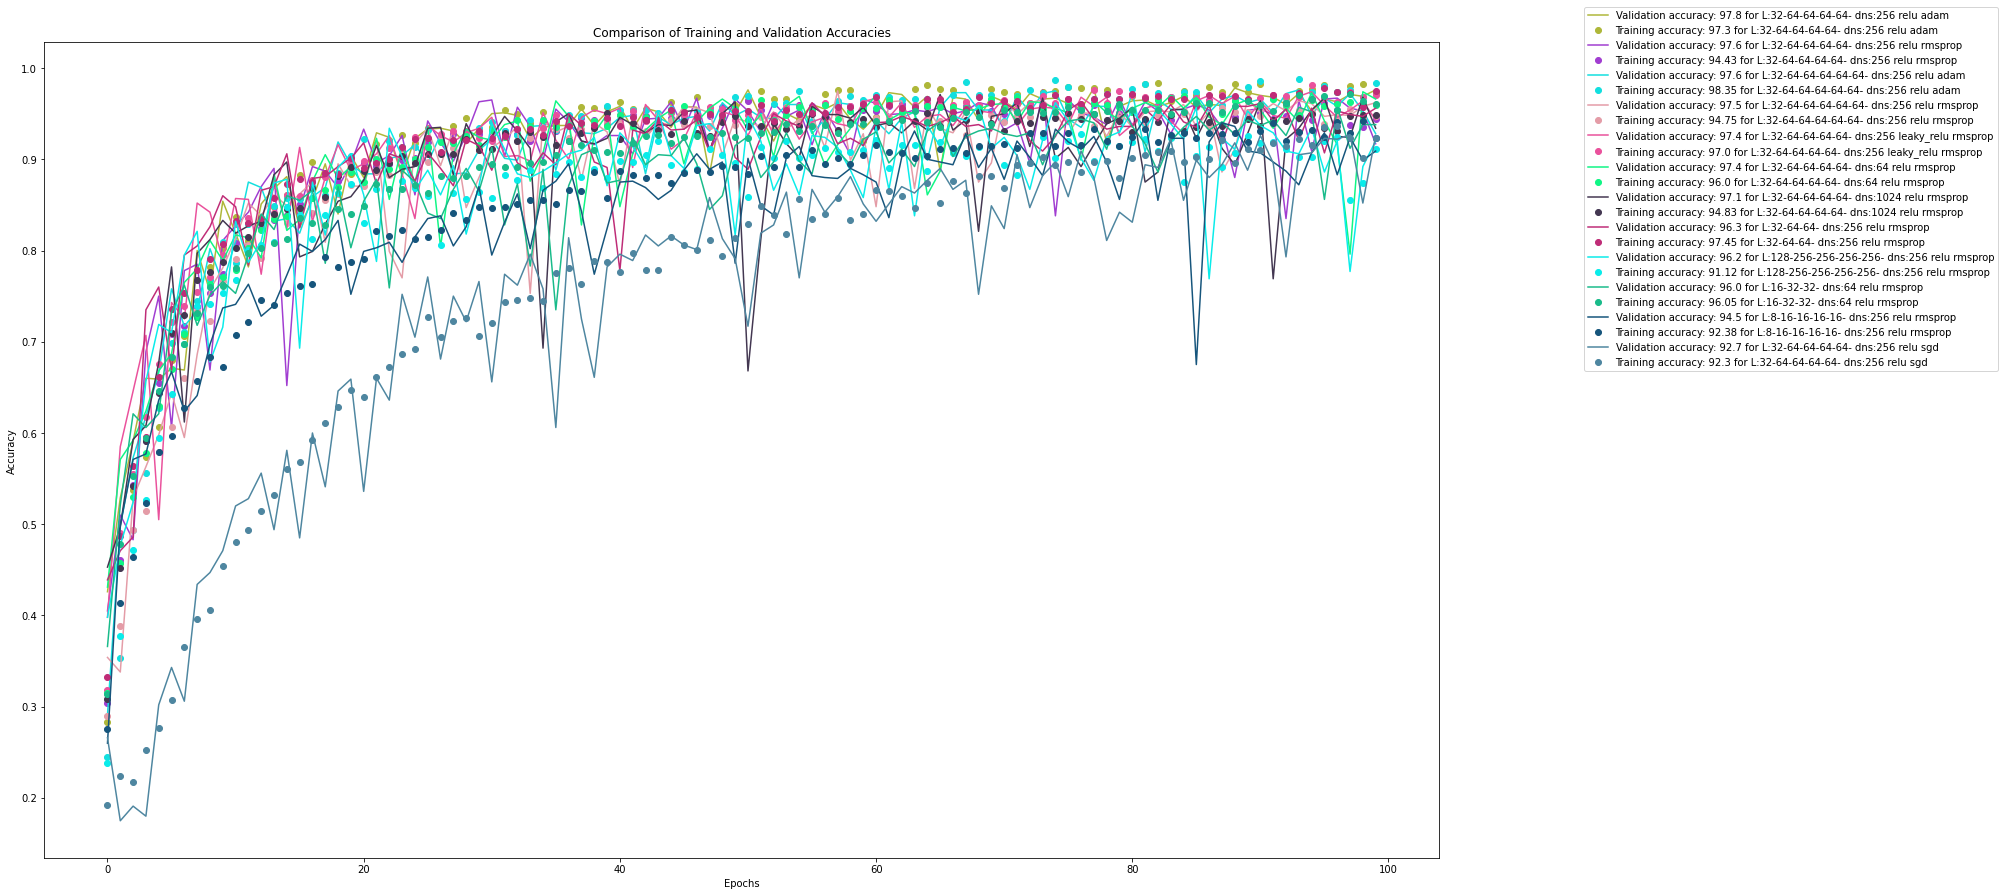

<Figure size 432x288 with 0 Axes>

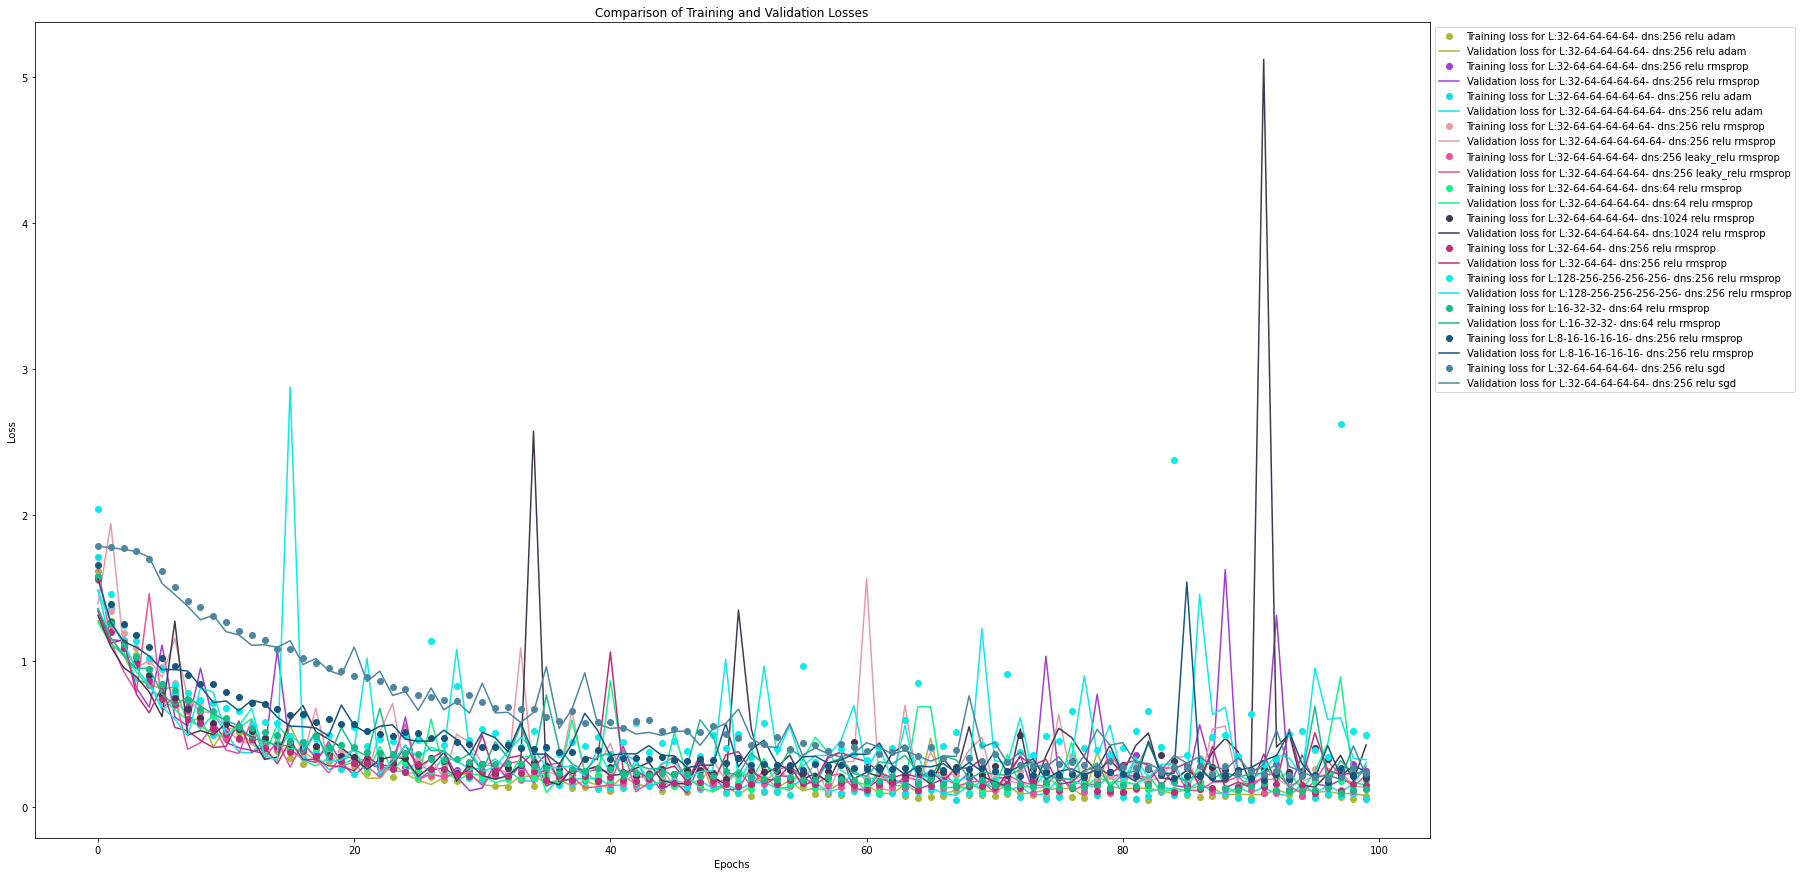

In [5]:
PlotAccuracyComparison(nc1)
PlotLossComparison(nc1)

<Figure size 432x288 with 0 Axes>

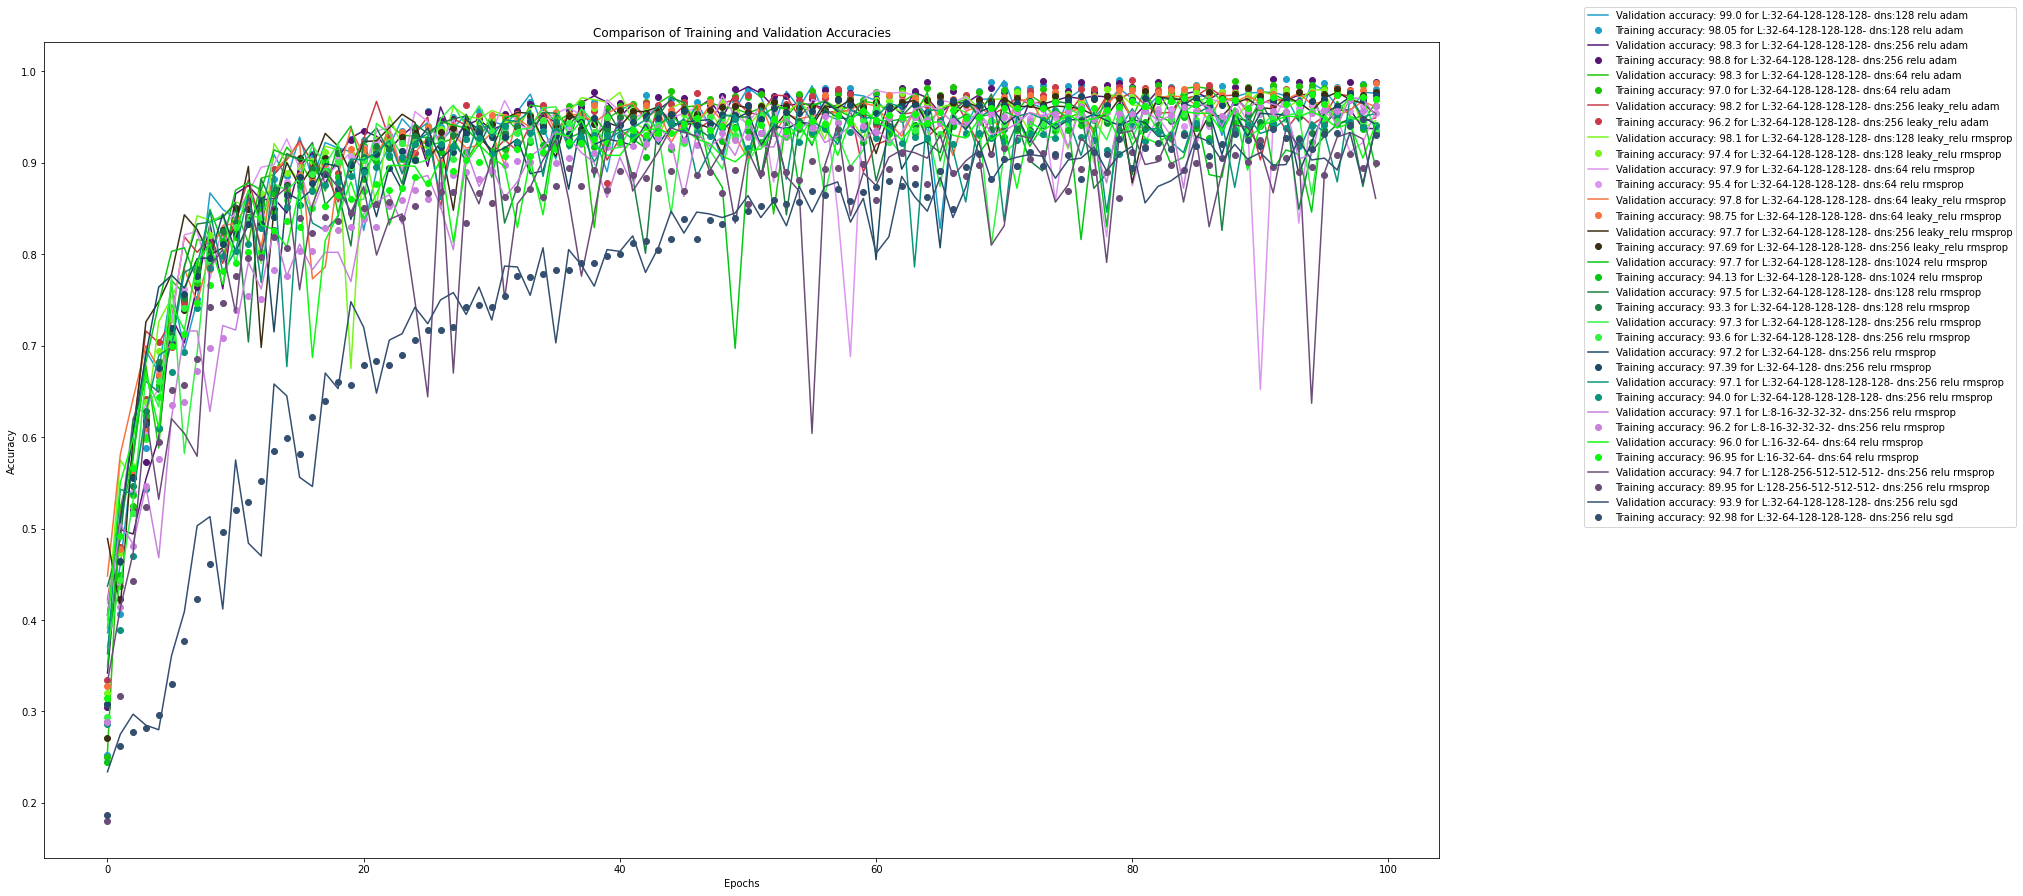

<Figure size 432x288 with 0 Axes>

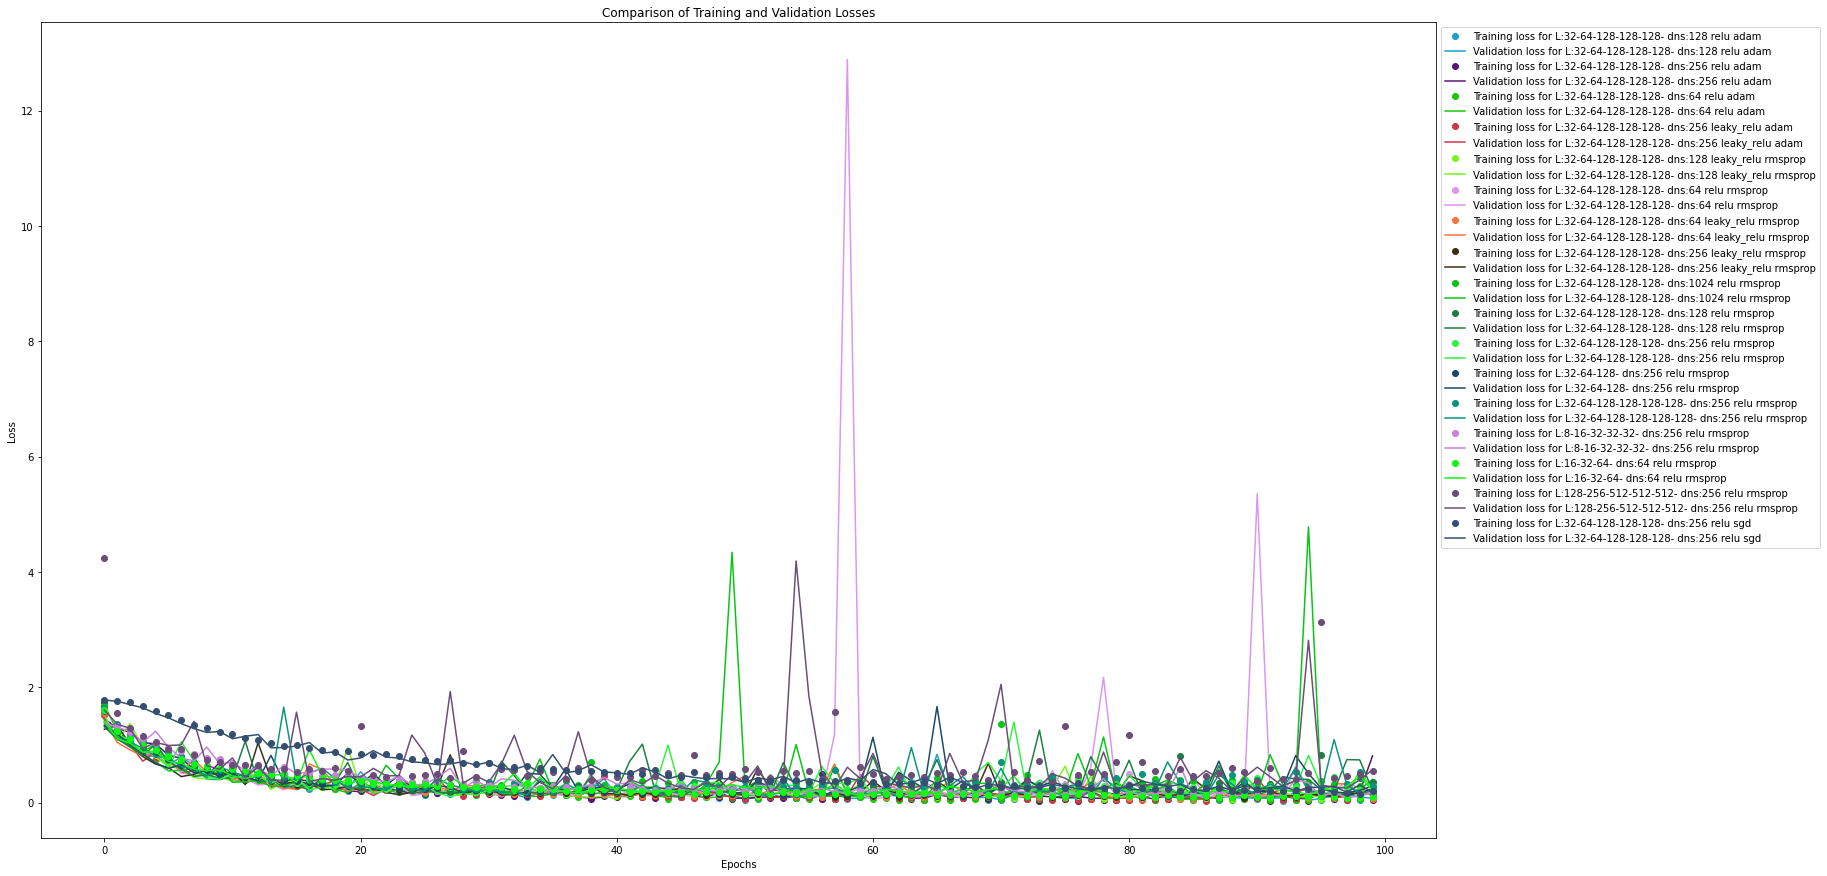

In [6]:
PlotAccuracyComparison(nc2)
PlotLossComparison(nc2)

<Figure size 432x288 with 0 Axes>

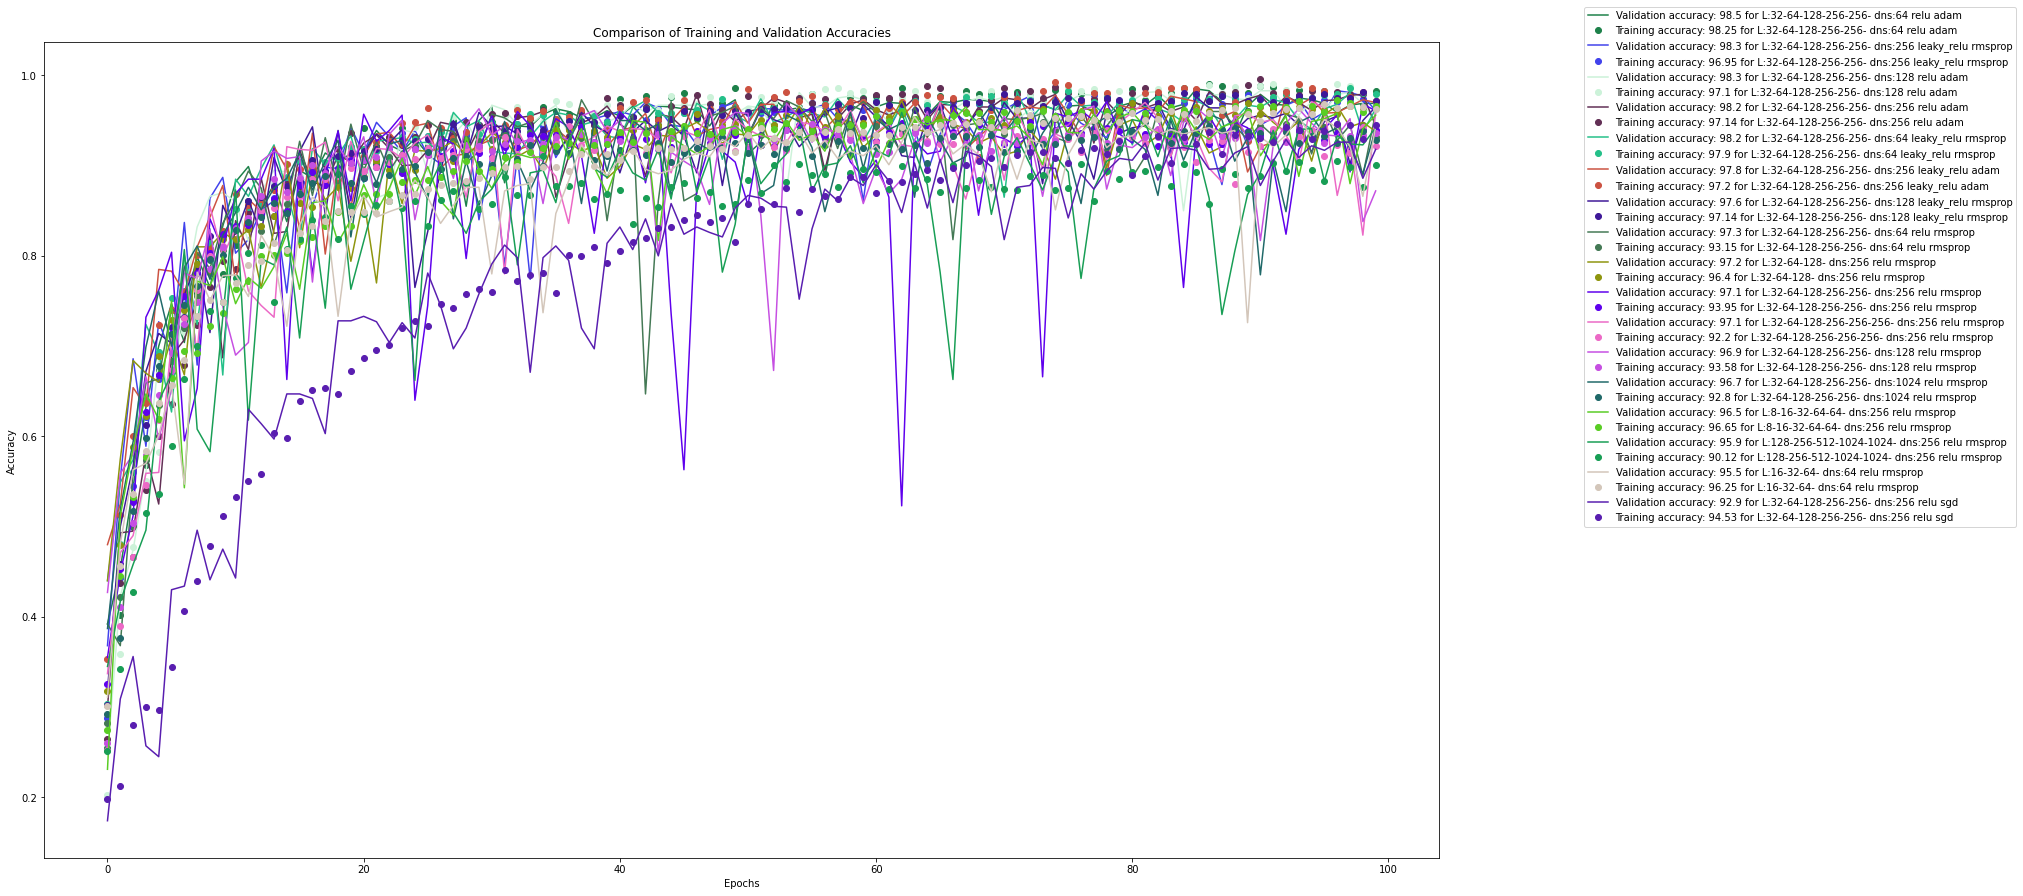

<Figure size 432x288 with 0 Axes>

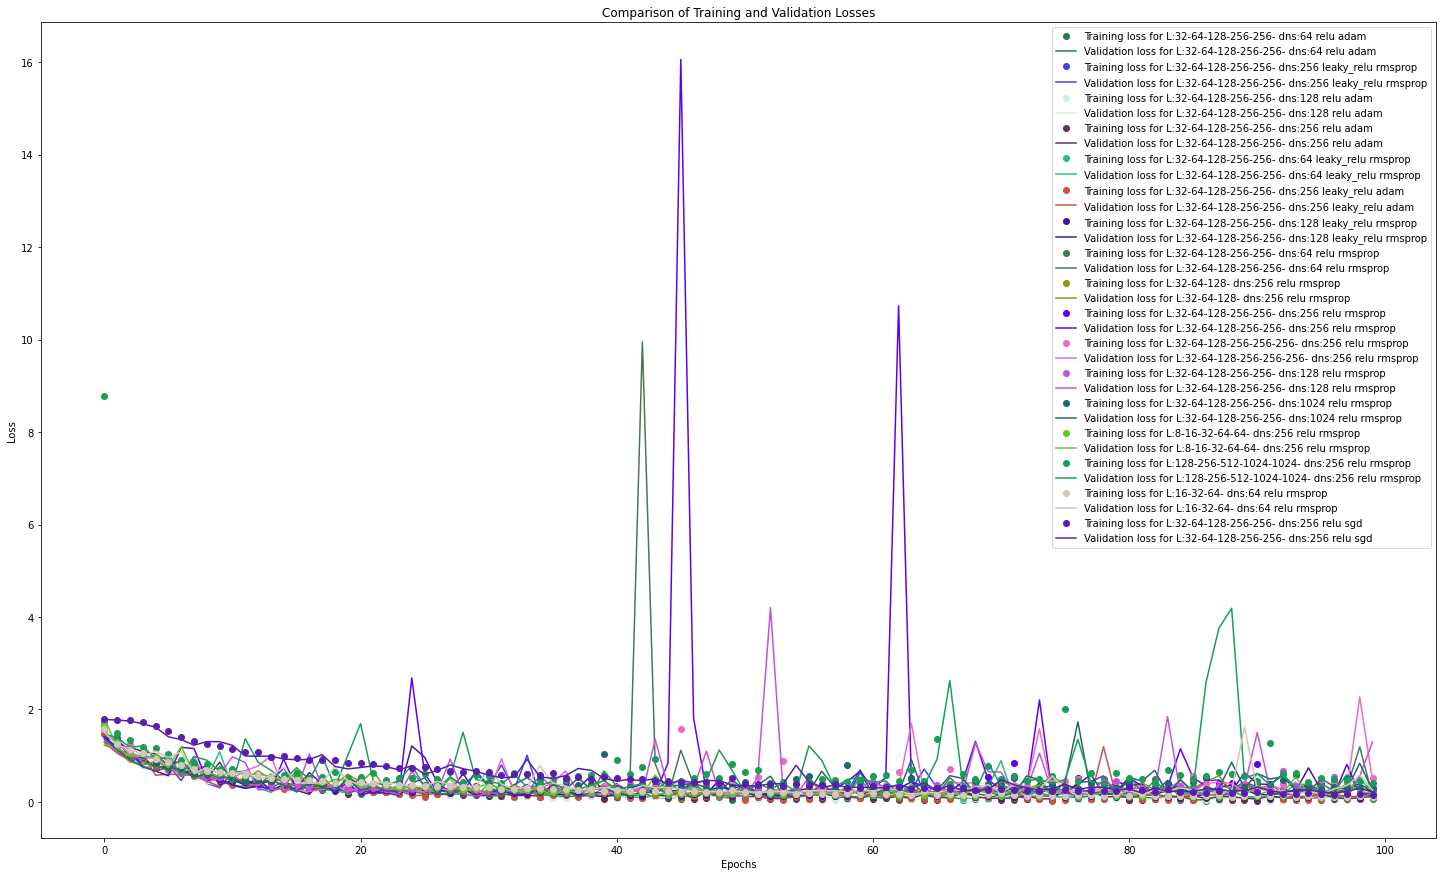

In [7]:
PlotAccuracyComparison(nc3)
PlotLossComparison(nc3)

Wszystkie modele zostały również zapisane do listy totalBest, która jest listą rankingową wszystkich modeli na raz.

In [25]:
totalBest = []

for m in nc1:
  totalBest.append(m)
for m in nc2:
  totalBest.append(m)
for m in nc3:
  totalBest.append(m)

for m1, m2, m3 in zip(bestNC1, bestNC2, bestNC3):
  totalBest.append(m1)
  totalBest.append(m2)
  totalBest.append(m3)


totalBest.sort(key=lambda x: x[2]['val_acc'][-1], reverse=True)

i = 1
for b in totalBest:
  print(str(i) + ". " + str(b[1]) + "\t\t\t" + str(b[2]['val_acc'][-1]))
  i += 1

1. L:32-64-64-64-64- dns:256 relu adam			0.9760000705718994
2. L:32-64-128-128-128- dns:128 relu adam			0.9760000705718994
3. L:32-64-128-128-128- dns:128 relu adam trained for 70 epochs			0.9730000495910645
4. L:32-64-128-256-256- dns:256 leaky_relu rmsprop trained for 96 epochs			0.971000075340271
5. L:32-64-128-128-128- dns:64 relu adam trained for 85 epochs			0.971000075340271
6. L:32-64-128-256-256- dns:256 leaky_relu adam			0.9700000286102295
7. L:32-64-128-256-256- dns:64 relu adam			0.9690000414848328
8. L:32-64-64-64-64- dns:256 relu adam trained for 77 epochs			0.968000054359436
9. L:32-64-128-256-256- dns:128 relu adam trained for 90 epochs			0.968000054359436
10. L:32-64-64-64-64- dns:64 relu rmsprop			0.9660000205039978
11. L:32-64-128-128-128- dns:64 relu adam			0.9660000205039978
12. L:32-64-128-128-128- dns:256 relu adam trained for 50 epochs			0.9660000205039978
13. L:32-64-128-256-256- dns:128 leaky_relu rmsprop			0.9650000333786011
14. L:32-64-128-256-256- dns:64 lea

In [5]:
for i in range(len(totalBest)):
  totalBest[i][0].save('C:/ml/models/pills_final_ranking/' + str(i + 1) + '.h5')
  toSave = [
    totalBest[i][1],
    totalBest[i][2],
    totalBest[i][3],
    totalBest[i][4],
    totalBest[i][5],
    totalBest[i][6],
  ]
  json.dump(toSave, open('C:/ml/models/pills_final_ranking/' + str(i + 1) + '.json', 'w'))